# Run torsion scans

In [1]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools import states
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


logger = logging.getLogger()
logger.setLevel(logging.INFO)


DEBUG:matplotlib:(private) matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warn

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
INFO:rdkit:Enabling RDKit 2020.09.1 jupyter extensions


### Define helper function for alchemifying

In [2]:
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTStateV2
from openmmtools.constants import kB

def alchemify(htf, endstate):

    # Define simulation parameters
    temperature = 1200 * unit.kelvin
    nsteps = 100000
    timestep = 4.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds
    
    # Create REST system
#     factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(669, 683)) + list(range(14877, 14881)))
#     factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(669, 683)) + list(range(14877, 14881)) + list(range(604, 628))) # W38
    factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(669, 683)) + list(range(14877, 14881)) + list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322))) # all within 5 A
#     factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(1441))) # whole protein
#    factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(669, 683)) + list(range(1444, 1448)) + list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322))) # all within 5 A, for vacuum
    REST_system = factory.REST_system
    
    
    # Create states
    T_min = 298 *unit.kelvin
    beta_0 = 1/(kB*T_min)
    beta_m = 1/(kB*temperature)
    lambda_zero_alchemical_state = RESTStateV2.from_system(REST_system)
    thermostate = ThermodynamicState(REST_system, temperature=T_min)
    compound_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])
    compound_state.set_alchemical_parameters(beta_0, beta_m)
    sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())

    system = REST_system
    positions = htf.hybrid_positions

    # Set up integrator
    integrator = LangevinIntegrator(T_min, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = compound_state.create_context(integrator, platform=platform)    

    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(T_min)
    print(compound_state.reduced_potential(context))
    
#     md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")

    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

#     # Run equilibration
#     for step in tqdm(range(nsteps)):
#         integrator.step(1)
    
    return context, compound_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [4]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
#     d_masses = {}
#     # Set particle masses to 0
#     for index in hybrid_indices:
#         d_masses[index] = htf.hybrid_system.getParticleMass(index)
#         htf.hybrid_system.setParticleMass(index, 0.0)
    
#     # Turn off constraints involving massless particles
#     for i in reversed(range(htf.hybrid_system.getNumConstraints())):
#         p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
#         if p1 in hybrid_indices or p2 in hybrid_indices:
#             if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
#                 htf.hybrid_system.removeConstraint(i)
    
    # Create context, compound state
    context, compound_state = alchemify(htf, endstate)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(compound_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(compound_state, sampler_state)
        
        sampler_state.apply_to_context(context)
        energy = compound_state.reduced_potential(context)
        energies = [energy]
#         openmm.LocalEnergyMinimizer.minimize(context)
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
#     # Set masses back to normal
#     for index in hybrid_indices:
#         compound_state.system.setParticleMass(index, d_masses[index])
#     compound_state.apply_to_context(context)
    
    return d_corrected
    
    

## Barnase:barstar T42A r-htf + REST2 (flattened torsions and exceptions) @ lambda = 0

In [5]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/0/"

with open(os.path.join(data_dir, f"0_apo_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

    
# with open(os.path.join(data_dir, f"0_apo_vacuum_0.pickle"), "rb") as f:
#     rhtf = pickle.load(f)
# # Remove barostat
# rhtf.hybrid_system.removeForce(0)

In [10]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
LYS1-N 6
LYS1-CA 7
LYS1-C 8
LYS1-O 9
LYS1-CB 10
LYS1-CG 11
LYS1-CD 12
LYS1-CE 13
LYS1-NZ 14
LYS1-H2 15
LYS1-HA 16
LYS1-HB3 17
LYS1-HB2 18
LYS1-HG2 19
LYS1-HG3 20
LYS1-HD2 21
LYS1-HD3 22
LYS1-HE3 23
LYS1-HE2 24
LYS1-HZ1 25
LYS1-HZ2 26
LYS1-HZ3 27
LYS2-N 28
LYS2-CA 29
LYS2-C 30
LYS2-O 31
LYS2-CB 32
LYS2-CG 33
LYS2-CD 34
LYS2-CE 35
LYS2-NZ 36
LYS2-H 37
LYS2-HA 38
LYS2-HB3 39
LYS2-HB2 40
LYS2-HG2 41
LYS2-HG3 42
LYS2-HD3 43
LYS2-HD2 44
LYS2-HE3 45
LYS2-HE2 46
LYS2-HZ1 47
LYS2-HZ2 48
LYS2-HZ3 49
ALA3-N 50
ALA3-CA 51
ALA3-C 52
ALA3-O 53
ALA3-CB 54
ALA3-H 55
ALA3-HA 56
ALA3-HB1 57
ALA3-HB2 58
ALA3-HB3 59
VAL4-N 60
VAL4-CA 61
VAL4-C 62
VAL4-O 63
VAL4-CB 64
VAL4-CG1 65
VAL4-CG2 66
VAL4-H 67
VAL4-HA 68
VAL4-HB 69
VAL4-HG11 70
VAL4-HG12 71
VAL4-HG13 72
VAL4-HG21 73
VAL4-HG22 74
VAL4-HG23 75
ILE5-N 76
ILE5-CA 77
ILE5-C 78
ILE5-O 79
ILE5-CB 80
ILE5-CG1 81
ILE5-CG2 82
ILE5-CD1 83
ILE5-H 84
ILE5-HA 85
ILE5-HB 86
ILE5-HG13 87
ILE5-HG12 88
ILE5-

GLN61-HE22 1015
LEU62-N 1016
LEU62-CA 1017
LEU62-C 1018
LEU62-O 1019
LEU62-CB 1020
LEU62-CG 1021
LEU62-CD1 1022
LEU62-CD2 1023
LEU62-H 1024
LEU62-HA 1025
LEU62-HB3 1026
LEU62-HB2 1027
LEU62-HG 1028
LEU62-HD11 1029
LEU62-HD12 1030
LEU62-HD13 1031
LEU62-HD21 1032
LEU62-HD22 1033
LEU62-HD23 1034
THR63-N 1035
THR63-CA 1036
THR63-C 1037
THR63-O 1038
THR63-CB 1039
THR63-OG1 1040
THR63-CG2 1041
THR63-H 1042
THR63-HA 1043
THR63-HB 1044
THR63-HG1 1045
THR63-HG21 1046
THR63-HG22 1047
THR63-HG23 1048
GLU64-N 1049
GLU64-CA 1050
GLU64-C 1051
GLU64-O 1052
GLU64-CB 1053
GLU64-CG 1054
GLU64-CD 1055
GLU64-OE1 1056
GLU64-OE2 1057
GLU64-HB2 1058
GLU64-HB3 1059
GLU64-HG2 1060
GLU64-HG3 1061
GLU64-H 1062
GLU64-HA 1063
ASN65-N 1064
ASN65-CA 1065
ASN65-C 1066
ASN65-O 1067
ASN65-CB 1068
ASN65-CG 1069
ASN65-OD1 1070
ASN65-ND2 1071
ASN65-HB2 1072
ASN65-HB3 1073
ASN65-HD22 1074
ASN65-HD21 1075
ASN65-H 1076
ASN65-HA 1077
GLY66-N 1078
GLY66-CA 1079
GLY66-C 1080
GLY66-O 1081
GLY66-HA2 1082
GLY66-HA3 1083
GLY66-H 10

HOH284-H1 2015
HOH284-H2 2016
HOH285-O 2017
HOH285-H1 2018
HOH285-H2 2019
HOH286-O 2020
HOH286-H1 2021
HOH286-H2 2022
HOH287-O 2023
HOH287-H1 2024
HOH287-H2 2025
HOH288-O 2026
HOH288-H1 2027
HOH288-H2 2028
HOH289-O 2029
HOH289-H1 2030
HOH289-H2 2031
HOH290-O 2032
HOH290-H1 2033
HOH290-H2 2034
HOH291-O 2035
HOH291-H1 2036
HOH291-H2 2037
HOH292-O 2038
HOH292-H1 2039
HOH292-H2 2040
HOH293-O 2041
HOH293-H1 2042
HOH293-H2 2043
HOH294-O 2044
HOH294-H1 2045
HOH294-H2 2046
HOH295-O 2047
HOH295-H1 2048
HOH295-H2 2049
HOH296-O 2050
HOH296-H1 2051
HOH296-H2 2052
HOH297-O 2053
HOH297-H1 2054
HOH297-H2 2055
HOH298-O 2056
HOH298-H1 2057
HOH298-H2 2058
HOH299-O 2059
HOH299-H1 2060
HOH299-H2 2061
HOH300-O 2062
HOH300-H1 2063
HOH300-H2 2064
HOH301-O 2065
HOH301-H1 2066
HOH301-H2 2067
HOH302-O 2068
HOH302-H1 2069
HOH302-H2 2070
HOH303-O 2071
HOH303-H1 2072
HOH303-H2 2073
HOH304-O 2074
HOH304-H1 2075
HOH304-H2 2076
HOH305-O 2077
HOH305-H1 2078
HOH305-H2 2079
HOH306-O 2080
HOH306-H1 2081
HOH306-H2 2082
HO

HOH617-H1 3014
HOH617-H2 3015
HOH618-O 3016
HOH618-H1 3017
HOH618-H2 3018
HOH619-O 3019
HOH619-H1 3020
HOH619-H2 3021
HOH620-O 3022
HOH620-H1 3023
HOH620-H2 3024
HOH621-O 3025
HOH621-H1 3026
HOH621-H2 3027
HOH622-O 3028
HOH622-H1 3029
HOH622-H2 3030
HOH623-O 3031
HOH623-H1 3032
HOH623-H2 3033
HOH624-O 3034
HOH624-H1 3035
HOH624-H2 3036
HOH625-O 3037
HOH625-H1 3038
HOH625-H2 3039
HOH626-O 3040
HOH626-H1 3041
HOH626-H2 3042
HOH627-O 3043
HOH627-H1 3044
HOH627-H2 3045
HOH628-O 3046
HOH628-H1 3047
HOH628-H2 3048
HOH629-O 3049
HOH629-H1 3050
HOH629-H2 3051
HOH630-O 3052
HOH630-H1 3053
HOH630-H2 3054
HOH631-O 3055
HOH631-H1 3056
HOH631-H2 3057
HOH632-O 3058
HOH632-H1 3059
HOH632-H2 3060
HOH633-O 3061
HOH633-H1 3062
HOH633-H2 3063
HOH634-O 3064
HOH634-H1 3065
HOH634-H2 3066
HOH635-O 3067
HOH635-H1 3068
HOH635-H2 3069
HOH636-O 3070
HOH636-H1 3071
HOH636-H2 3072
HOH637-O 3073
HOH637-H1 3074
HOH637-H2 3075
HOH638-O 3076
HOH638-H1 3077
HOH638-H2 3078
HOH639-O 3079
HOH639-H1 3080
HOH639-H2 3081
HO

HOH952-H2 4014
HOH953-O 4015
HOH953-H1 4016
HOH953-H2 4017
HOH954-O 4018
HOH954-H1 4019
HOH954-H2 4020
HOH955-O 4021
HOH955-H1 4022
HOH955-H2 4023
HOH956-O 4024
HOH956-H1 4025
HOH956-H2 4026
HOH957-O 4027
HOH957-H1 4028
HOH957-H2 4029
HOH958-O 4030
HOH958-H1 4031
HOH958-H2 4032
HOH959-O 4033
HOH959-H1 4034
HOH959-H2 4035
HOH960-O 4036
HOH960-H1 4037
HOH960-H2 4038
HOH961-O 4039
HOH961-H1 4040
HOH961-H2 4041
HOH962-O 4042
HOH962-H1 4043
HOH962-H2 4044
HOH963-O 4045
HOH963-H1 4046
HOH963-H2 4047
HOH964-O 4048
HOH964-H1 4049
HOH964-H2 4050
HOH965-O 4051
HOH965-H1 4052
HOH965-H2 4053
HOH966-O 4054
HOH966-H1 4055
HOH966-H2 4056
HOH967-O 4057
HOH967-H1 4058
HOH967-H2 4059
HOH968-O 4060
HOH968-H1 4061
HOH968-H2 4062
HOH969-O 4063
HOH969-H1 4064
HOH969-H2 4065
HOH970-O 4066
HOH970-H1 4067
HOH970-H2 4068
HOH971-O 4069
HOH971-H1 4070
HOH971-H2 4071
HOH972-O 4072
HOH972-H1 4073
HOH972-H2 4074
HOH973-O 4075
HOH973-H1 4076
HOH973-H2 4077
HOH974-O 4078
HOH974-H1 4079
HOH974-H2 4080
HOH975-O 4081
HOH

HOH1288-O 5014
HOH1288-H1 5015
HOH1288-H2 5016
HOH1289-O 5017
HOH1289-H1 5018
HOH1289-H2 5019
HOH1290-O 5020
HOH1290-H1 5021
HOH1290-H2 5022
HOH1291-O 5023
HOH1291-H1 5024
HOH1291-H2 5025
HOH1292-O 5026
HOH1292-H1 5027
HOH1292-H2 5028
HOH1293-O 5029
HOH1293-H1 5030
HOH1293-H2 5031
HOH1294-O 5032
HOH1294-H1 5033
HOH1294-H2 5034
HOH1295-O 5035
HOH1295-H1 5036
HOH1295-H2 5037
HOH1296-O 5038
HOH1296-H1 5039
HOH1296-H2 5040
HOH1297-O 5041
HOH1297-H1 5042
HOH1297-H2 5043
HOH1298-O 5044
HOH1298-H1 5045
HOH1298-H2 5046
HOH1299-O 5047
HOH1299-H1 5048
HOH1299-H2 5049
HOH1300-O 5050
HOH1300-H1 5051
HOH1300-H2 5052
HOH1301-O 5053
HOH1301-H1 5054
HOH1301-H2 5055
HOH1302-O 5056
HOH1302-H1 5057
HOH1302-H2 5058
HOH1303-O 5059
HOH1303-H1 5060
HOH1303-H2 5061
HOH1304-O 5062
HOH1304-H1 5063
HOH1304-H2 5064
HOH1305-O 5065
HOH1305-H1 5066
HOH1305-H2 5067
HOH1306-O 5068
HOH1306-H1 5069
HOH1306-H2 5070
HOH1307-O 5071
HOH1307-H1 5072
HOH1307-H2 5073
HOH1308-O 5074
HOH1308-H1 5075
HOH1308-H2 5076
HOH1309-O 507

HOH1623-H1 6014
HOH1623-H2 6015
HOH1624-O 6016
HOH1624-H1 6017
HOH1624-H2 6018
HOH1625-O 6019
HOH1625-H1 6020
HOH1625-H2 6021
HOH1626-O 6022
HOH1626-H1 6023
HOH1626-H2 6024
HOH1627-O 6025
HOH1627-H1 6026
HOH1627-H2 6027
HOH1628-O 6028
HOH1628-H1 6029
HOH1628-H2 6030
HOH1629-O 6031
HOH1629-H1 6032
HOH1629-H2 6033
HOH1630-O 6034
HOH1630-H1 6035
HOH1630-H2 6036
HOH1631-O 6037
HOH1631-H1 6038
HOH1631-H2 6039
HOH1632-O 6040
HOH1632-H1 6041
HOH1632-H2 6042
HOH1633-O 6043
HOH1633-H1 6044
HOH1633-H2 6045
HOH1634-O 6046
HOH1634-H1 6047
HOH1634-H2 6048
HOH1635-O 6049
HOH1635-H1 6050
HOH1635-H2 6051
HOH1636-O 6052
HOH1636-H1 6053
HOH1636-H2 6054
HOH1637-O 6055
HOH1637-H1 6056
HOH1637-H2 6057
HOH1638-O 6058
HOH1638-H1 6059
HOH1638-H2 6060
HOH1639-O 6061
HOH1639-H1 6062
HOH1639-H2 6063
HOH1640-O 6064
HOH1640-H1 6065
HOH1640-H2 6066
HOH1641-O 6067
HOH1641-H1 6068
HOH1641-H2 6069
HOH1642-O 6070
HOH1642-H1 6071
HOH1642-H2 6072
HOH1643-O 6073
HOH1643-H1 6074
HOH1643-H2 6075
HOH1644-O 6076
HOH1644-H1 60

HOH1957-H1 7013
HOH1957-H2 7014
HOH1958-O 7015
HOH1958-H1 7016
HOH1958-H2 7017
HOH1959-O 7018
HOH1959-H1 7019
HOH1959-H2 7020
HOH1960-O 7021
HOH1960-H1 7022
HOH1960-H2 7023
HOH1961-O 7024
HOH1961-H1 7025
HOH1961-H2 7026
HOH1962-O 7027
HOH1962-H1 7028
HOH1962-H2 7029
HOH1963-O 7030
HOH1963-H1 7031
HOH1963-H2 7032
HOH1964-O 7033
HOH1964-H1 7034
HOH1964-H2 7035
HOH1965-O 7036
HOH1965-H1 7037
HOH1965-H2 7038
HOH1966-O 7039
HOH1966-H1 7040
HOH1966-H2 7041
HOH1967-O 7042
HOH1967-H1 7043
HOH1967-H2 7044
HOH1968-O 7045
HOH1968-H1 7046
HOH1968-H2 7047
HOH1969-O 7048
HOH1969-H1 7049
HOH1969-H2 7050
HOH1970-O 7051
HOH1970-H1 7052
HOH1970-H2 7053
HOH1971-O 7054
HOH1971-H1 7055
HOH1971-H2 7056
HOH1972-O 7057
HOH1972-H1 7058
HOH1972-H2 7059
HOH1973-O 7060
HOH1973-H1 7061
HOH1973-H2 7062
HOH1974-O 7063
HOH1974-H1 7064
HOH1974-H2 7065
HOH1975-O 7066
HOH1975-H1 7067
HOH1975-H2 7068
HOH1976-O 7069
HOH1976-H1 7070
HOH1976-H2 7071
HOH1977-O 7072
HOH1977-H1 7073
HOH1977-H2 7074
HOH1978-O 7075
HOH1978-H1 70

HOH2291-H2 8013
HOH2292-O 8014
HOH2292-H1 8015
HOH2292-H2 8016
HOH2293-O 8017
HOH2293-H1 8018
HOH2293-H2 8019
HOH2294-O 8020
HOH2294-H1 8021
HOH2294-H2 8022
HOH2295-O 8023
HOH2295-H1 8024
HOH2295-H2 8025
HOH2296-O 8026
HOH2296-H1 8027
HOH2296-H2 8028
HOH2297-O 8029
HOH2297-H1 8030
HOH2297-H2 8031
HOH2298-O 8032
HOH2298-H1 8033
HOH2298-H2 8034
HOH2299-O 8035
HOH2299-H1 8036
HOH2299-H2 8037
HOH2300-O 8038
HOH2300-H1 8039
HOH2300-H2 8040
HOH2301-O 8041
HOH2301-H1 8042
HOH2301-H2 8043
HOH2302-O 8044
HOH2302-H1 8045
HOH2302-H2 8046
HOH2303-O 8047
HOH2303-H1 8048
HOH2303-H2 8049
HOH2304-O 8050
HOH2304-H1 8051
HOH2304-H2 8052
HOH2305-O 8053
HOH2305-H1 8054
HOH2305-H2 8055
HOH2306-O 8056
HOH2306-H1 8057
HOH2306-H2 8058
HOH2307-O 8059
HOH2307-H1 8060
HOH2307-H2 8061
HOH2308-O 8062
HOH2308-H1 8063
HOH2308-H2 8064
HOH2309-O 8065
HOH2309-H1 8066
HOH2309-H2 8067
HOH2310-O 8068
HOH2310-H1 8069
HOH2310-H2 8070
HOH2311-O 8071
HOH2311-H1 8072
HOH2311-H2 8073
HOH2312-O 8074
HOH2312-H1 8075
HOH2312-H2 80

HOH2625-O 9013
HOH2625-H1 9014
HOH2625-H2 9015
HOH2626-O 9016
HOH2626-H1 9017
HOH2626-H2 9018
HOH2627-O 9019
HOH2627-H1 9020
HOH2627-H2 9021
HOH2628-O 9022
HOH2628-H1 9023
HOH2628-H2 9024
HOH2629-O 9025
HOH2629-H1 9026
HOH2629-H2 9027
HOH2630-O 9028
HOH2630-H1 9029
HOH2630-H2 9030
HOH2631-O 9031
HOH2631-H1 9032
HOH2631-H2 9033
HOH2632-O 9034
HOH2632-H1 9035
HOH2632-H2 9036
HOH2633-O 9037
HOH2633-H1 9038
HOH2633-H2 9039
HOH2634-O 9040
HOH2634-H1 9041
HOH2634-H2 9042
HOH2635-O 9043
HOH2635-H1 9044
HOH2635-H2 9045
HOH2636-O 9046
HOH2636-H1 9047
HOH2636-H2 9048
HOH2637-O 9049
HOH2637-H1 9050
HOH2637-H2 9051
HOH2638-O 9052
HOH2638-H1 9053
HOH2638-H2 9054
HOH2639-O 9055
HOH2639-H1 9056
HOH2639-H2 9057
HOH2640-O 9058
HOH2640-H1 9059
HOH2640-H2 9060
HOH2641-O 9061
HOH2641-H1 9062
HOH2641-H2 9063
HOH2642-O 9064
HOH2642-H1 9065
HOH2642-H2 9066
HOH2643-O 9067
HOH2643-H1 9068
HOH2643-H2 9069
HOH2644-O 9070
HOH2644-H1 9071
HOH2644-H2 9072
HOH2645-O 9073
HOH2645-H1 9074
HOH2645-H2 9075
HOH2646-O 907

HOH2959-H1 10013
HOH2959-H2 10014
HOH2960-O 10015
HOH2960-H1 10016
HOH2960-H2 10017
HOH2961-O 10018
HOH2961-H1 10019
HOH2961-H2 10020
HOH2962-O 10021
HOH2962-H1 10022
HOH2962-H2 10023
HOH2963-O 10024
HOH2963-H1 10025
HOH2963-H2 10026
HOH2964-O 10027
HOH2964-H1 10028
HOH2964-H2 10029
HOH2965-O 10030
HOH2965-H1 10031
HOH2965-H2 10032
HOH2966-O 10033
HOH2966-H1 10034
HOH2966-H2 10035
HOH2967-O 10036
HOH2967-H1 10037
HOH2967-H2 10038
HOH2968-O 10039
HOH2968-H1 10040
HOH2968-H2 10041
HOH2969-O 10042
HOH2969-H1 10043
HOH2969-H2 10044
HOH2970-O 10045
HOH2970-H1 10046
HOH2970-H2 10047
HOH2971-O 10048
HOH2971-H1 10049
HOH2971-H2 10050
HOH2972-O 10051
HOH2972-H1 10052
HOH2972-H2 10053
HOH2973-O 10054
HOH2973-H1 10055
HOH2973-H2 10056
HOH2974-O 10057
HOH2974-H1 10058
HOH2974-H2 10059
HOH2975-O 10060
HOH2975-H1 10061
HOH2975-H2 10062
HOH2976-O 10063
HOH2976-H1 10064
HOH2976-H2 10065
HOH2977-O 10066
HOH2977-H1 10067
HOH2977-H2 10068
HOH2978-O 10069
HOH2978-H1 10070
HOH2978-H2 10071
HOH2979-O 10072


HOH3293-H1 11012
HOH3293-H2 11013
HOH3294-O 11014
HOH3294-H1 11015
HOH3294-H2 11016
HOH3295-O 11017
HOH3295-H1 11018
HOH3295-H2 11019
HOH3296-O 11020
HOH3296-H1 11021
HOH3296-H2 11022
HOH3297-O 11023
HOH3297-H1 11024
HOH3297-H2 11025
HOH3298-O 11026
HOH3298-H1 11027
HOH3298-H2 11028
HOH3299-O 11029
HOH3299-H1 11030
HOH3299-H2 11031
HOH3300-O 11032
HOH3300-H1 11033
HOH3300-H2 11034
HOH3301-O 11035
HOH3301-H1 11036
HOH3301-H2 11037
HOH3302-O 11038
HOH3302-H1 11039
HOH3302-H2 11040
HOH3303-O 11041
HOH3303-H1 11042
HOH3303-H2 11043
HOH3304-O 11044
HOH3304-H1 11045
HOH3304-H2 11046
HOH3305-O 11047
HOH3305-H1 11048
HOH3305-H2 11049
HOH3306-O 11050
HOH3306-H1 11051
HOH3306-H2 11052
HOH3307-O 11053
HOH3307-H1 11054
HOH3307-H2 11055
HOH3308-O 11056
HOH3308-H1 11057
HOH3308-H2 11058
HOH3309-O 11059
HOH3309-H1 11060
HOH3309-H2 11061
HOH3310-O 11062
HOH3310-H1 11063
HOH3310-H2 11064
HOH3311-O 11065
HOH3311-H1 11066
HOH3311-H2 11067
HOH3312-O 11068
HOH3312-H1 11069
HOH3312-H2 11070
HOH3313-O 11071


HOH3711-O 12262
HOH3711-H1 12263
HOH3711-H2 12264
HOH3712-O 12265
HOH3712-H1 12266
HOH3712-H2 12267
HOH3713-O 12268
HOH3713-H1 12269
HOH3713-H2 12270
HOH3714-O 12271
HOH3714-H1 12272
HOH3714-H2 12273
HOH3715-O 12274
HOH3715-H1 12275
HOH3715-H2 12276
HOH3716-O 12277
HOH3716-H1 12278
HOH3716-H2 12279
HOH3717-O 12280
HOH3717-H1 12281
HOH3717-H2 12282
HOH3718-O 12283
HOH3718-H1 12284
HOH3718-H2 12285
HOH3719-O 12286
HOH3719-H1 12287
HOH3719-H2 12288
HOH3720-O 12289
HOH3720-H1 12290
HOH3720-H2 12291
HOH3721-O 12292
HOH3721-H1 12293
HOH3721-H2 12294
HOH3722-O 12295
HOH3722-H1 12296
HOH3722-H2 12297
HOH3723-O 12298
HOH3723-H1 12299
HOH3723-H2 12300
HOH3724-O 12301
HOH3724-H1 12302
HOH3724-H2 12303
HOH3725-O 12304
HOH3725-H1 12305
HOH3725-H2 12306
HOH3726-O 12307
HOH3726-H1 12308
HOH3726-H2 12309
HOH3727-O 12310
HOH3727-H1 12311
HOH3727-H2 12312
HOH3728-O 12313
HOH3728-H1 12314
HOH3728-H2 12315
HOH3729-O 12316
HOH3729-H1 12317
HOH3729-H2 12318
HOH3730-O 12319
HOH3730-H1 12320
HOH3730-H2 12321


HOH4127-H2 13512
HOH4128-O 13513
HOH4128-H1 13514
HOH4128-H2 13515
HOH4129-O 13516
HOH4129-H1 13517
HOH4129-H2 13518
HOH4130-O 13519
HOH4130-H1 13520
HOH4130-H2 13521
HOH4131-O 13522
HOH4131-H1 13523
HOH4131-H2 13524
HOH4132-O 13525
HOH4132-H1 13526
HOH4132-H2 13527
HOH4133-O 13528
HOH4133-H1 13529
HOH4133-H2 13530
HOH4134-O 13531
HOH4134-H1 13532
HOH4134-H2 13533
HOH4135-O 13534
HOH4135-H1 13535
HOH4135-H2 13536
HOH4136-O 13537
HOH4136-H1 13538
HOH4136-H2 13539
HOH4137-O 13540
HOH4137-H1 13541
HOH4137-H2 13542
HOH4138-O 13543
HOH4138-H1 13544
HOH4138-H2 13545
HOH4139-O 13546
HOH4139-H1 13547
HOH4139-H2 13548
HOH4140-O 13549
HOH4140-H1 13550
HOH4140-H2 13551
HOH4141-O 13552
HOH4141-H1 13553
HOH4141-H2 13554
HOH4142-O 13555
HOH4142-H1 13556
HOH4142-H2 13557
HOH4143-O 13558
HOH4143-H1 13559
HOH4143-H2 13560
HOH4144-O 13561
HOH4144-H1 13562
HOH4144-H2 13563
HOH4145-O 13564
HOH4145-H1 13565
HOH4145-H2 13566
HOH4146-O 13567
HOH4146-H1 13568
HOH4146-H2 13569
HOH4147-O 13570
HOH4147-H1 13571


HOH4545-H1 14762
HOH4545-H2 14763
HOH4546-O 14764
HOH4546-H1 14765
HOH4546-H2 14766
HOH4547-O 14767
HOH4547-H1 14768
HOH4547-H2 14769
HOH4548-O 14770
HOH4548-H1 14771
HOH4548-H2 14772
HOH4549-O 14773
HOH4549-H1 14774
HOH4549-H2 14775
HOH4550-O 14776
HOH4550-H1 14777
HOH4550-H2 14778
HOH4551-O 14779
HOH4551-H1 14780
HOH4551-H2 14781
HOH4552-O 14782
HOH4552-H1 14783
HOH4552-H2 14784
HOH4553-O 14785
HOH4553-H1 14786
HOH4553-H2 14787
HOH4554-O 14788
HOH4554-H1 14789
HOH4554-H2 14790
HOH4555-O 14791
HOH4555-H1 14792
HOH4555-H2 14793
HOH4556-O 14794
HOH4556-H1 14795
HOH4556-H2 14796
HOH4557-O 14797
HOH4557-H1 14798
HOH4557-H2 14799
HOH4558-O 14800
HOH4558-H1 14801
HOH4558-H2 14802
HOH4559-O 14803
HOH4559-H1 14804
HOH4559-H2 14805
HOH4560-O 14806
HOH4560-H1 14807
HOH4560-H2 14808
HOH4561-O 14809
HOH4561-H1 14810
HOH4561-H2 14811
HOH4562-O 14812
HOH4562-H1 14813
HOH4562-H2 14814
HOH4563-O 14815
HOH4563-H1 14816
HOH4563-H2 14817
HOH4564-O 14818
HOH4564-H1 14819
HOH4564-H2 14820
HOH4565-O 14821


INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=5.423900000000001, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=5.423900000000001, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=5.423900000000001), unit=nanometer)]
INFO:REST:No unknown forces.


3582.348512617011
1.1298606
3589.8476211369134


INFO:root:Rotating by 0.2635690157863959 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000156 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179585 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:roo

3606.4548423863353
3893.8053151449085
5874.840812620782
4637.068171111204
3969.538083928001
5840.284569852068
5188.102626761486
3707.800770784158
3606.787834652408
3606.0203130294612
3616.327775899782
3630.6594336575836
3635.985339728264
3638.286704721759
3644.774027457937
3634.0821443070654
3615.9974865055924
3613.722189052418
3626.520621704118
3647.3775314632167
3643.960967688424
3612.1618533190954
3591.8069995155897
3590.1991073034696


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


raw d: {1.3918606395721436: (3606.4548423863353, nan), 1.6538606395721436: (3893.8053151449085, nan), 1.9158606395721436: (5874.840812620782, nan), 2.1778606395721436: (4637.068171111204, nan), 2.4398606395721436: (3969.538083928001, nan), 2.7018606395721436: (5840.284569852068, nan), 2.9638606395721436: (5188.102626761486, nan), -3.0573246676074426: (3707.800770784158, nan), -2.7953246676074426: (3606.787834652408, nan), -2.5333246676074426: (3606.0203130294612, nan), -2.2713246676074426: (3616.327775899782, nan), -2.0093246676074425: (3630.6594336575836, nan), -1.7473246676074425: (3635.985339728264, nan), -1.4853246676074425: (3638.286704721759, nan), -1.2233246676074425: (3644.774027457937, nan), -0.9613246676074425: (3634.0821443070654, nan), -0.6993246676074425: (3615.9974865055924, nan), -0.4373246676074425: (3613.722189052418, nan), -0.17532466760744247: (3626.520621704118, nan), 0.08667533239255754: (3647.3775314632167, nan), 0.34867533239255755: (3643.960967688424, nan), 0.61

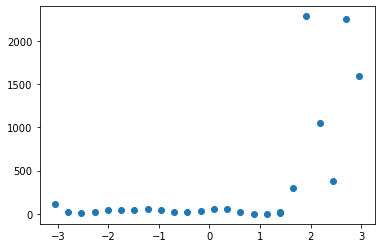

{1.3918606395721436: (16.255735082865613, nan),
 1.6538606395721436: (303.60620784143885, nan),
 1.9158606395721436: (2284.6417053173127, nan),
 2.1778606395721436: (1046.8690638077342, nan),
 2.4398606395721436: (379.33897662453137, nan),
 2.7018606395721436: (2250.085462548598, nan),
 2.9638606395721436: (1597.9035194580165, nan),
 -3.0573246676074426: (117.60166348068833, nan),
 -2.7953246676074426: (16.58872734893839, nan),
 -2.5333246676074426: (15.821205725991604, nan),
 -2.2713246676074426: (26.12866859631231, nan),
 -2.0093246676074425: (40.46032635411393, nan),
 -1.7473246676074425: (45.786232424794434, nan),
 -1.4853246676074425: (48.08759741828953, nan),
 -1.2233246676074425: (54.574920154467236, nan),
 -0.9613246676074425: (43.883037003595746, nan),
 -0.6993246676074425: (25.79837920212276, nan),
 -0.4373246676074425: (23.523081748948243, nan),
 -0.17532466760744247: (36.32151440064854, nan),
 0.08667533239255754: (57.17842415974701, nan),
 0.34867533239255755: (53.76186038

In [6]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [669, 670, 673, 674],  [669, 670, 673, 674], [675] + list(range(678, 683))) # solvent


In [ ]:
# Barrier is 4000 kJ/mol at 298 K (REST region = T42 only)
# Barrier is 3500 kJ/mol at 1200 K (REST region = T42 only)
# Barrier is 2500 kJ/mol at 1200 K (REST region = T42 + W38)
# Barrier is 1750 kJ/mol at 1200 K (REST region = T42A + residues in 5 A radius)
# Barrier is 4000 kJ/mol at 298 K (REST region = T42A + residues in 5 A radius)
# Barrier is 2500 kJ/mol at 1200 K (REST region = whole protein)
# The rest of the barrier may just be due to a solvent clash?

# Try much higher temp 
# Barrier is 2000 kJ/mol at 10000 K (REST region = T42A + residues in 5 A radius)
# Barrier is 2000 kJ/mol at 100000 K (REST region = T42A + residues in 5 A radius)


# Re-generated system in vacuum
# Barrier is 1000 kJ/mol at 1200 K (REST region = T42A + residues in 5 A radius)




In [ ]:
# L37 (first-585), W38, D39, A40, L41 (last-668), G43 (first-683), W44, V45 (last-729), Y47(745-765), A77(1248-1257), E80(1290-1304), A82 (1312-1321)

In [ ]:
list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322))

## Barnase:barstar T42A r-htf + REST2 (flattened torsions and exceptions) @ lambda = 0 -- play around with system

In [5]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/0/"

with open(os.path.join(data_dir, f"0_apo_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

    
# with open(os.path.join(data_dir, f"0_apo_vacuum_0.pickle"), "rb") as f:
#     rhtf = pickle.load(f)
# # Remove barostat
# rhtf.hybrid_system.removeForce(0)

In [6]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
LYS1-N 6
LYS1-CA 7
LYS1-C 8
LYS1-O 9
LYS1-CB 10
LYS1-CG 11
LYS1-CD 12
LYS1-CE 13
LYS1-NZ 14
LYS1-H2 15
LYS1-HA 16
LYS1-HB3 17
LYS1-HB2 18
LYS1-HG2 19
LYS1-HG3 20
LYS1-HD2 21
LYS1-HD3 22
LYS1-HE3 23
LYS1-HE2 24
LYS1-HZ1 25
LYS1-HZ2 26
LYS1-HZ3 27
LYS2-N 28
LYS2-CA 29
LYS2-C 30
LYS2-O 31
LYS2-CB 32
LYS2-CG 33
LYS2-CD 34
LYS2-CE 35
LYS2-NZ 36
LYS2-H 37
LYS2-HA 38
LYS2-HB3 39
LYS2-HB2 40
LYS2-HG2 41
LYS2-HG3 42
LYS2-HD3 43
LYS2-HD2 44
LYS2-HE3 45
LYS2-HE2 46
LYS2-HZ1 47
LYS2-HZ2 48
LYS2-HZ3 49
ALA3-N 50
ALA3-CA 51
ALA3-C 52
ALA3-O 53
ALA3-CB 54
ALA3-H 55
ALA3-HA 56
ALA3-HB1 57
ALA3-HB2 58
ALA3-HB3 59
VAL4-N 60
VAL4-CA 61
VAL4-C 62
VAL4-O 63
VAL4-CB 64
VAL4-CG1 65
VAL4-CG2 66
VAL4-H 67
VAL4-HA 68
VAL4-HB 69
VAL4-HG11 70
VAL4-HG12 71
VAL4-HG13 72
VAL4-HG21 73
VAL4-HG22 74
VAL4-HG23 75
ILE5-N 76
ILE5-CA 77
ILE5-C 78
ILE5-O 79
ILE5-CB 80
ILE5-CG1 81
ILE5-CG2 82
ILE5-CD1 83
ILE5-H 84
ILE5-HA 85
ILE5-HB 86
ILE5-HG13 87
ILE5-HG12 88
ILE5-

HOH266-H1 1961
HOH266-H2 1962
HOH267-O 1963
HOH267-H1 1964
HOH267-H2 1965
HOH268-O 1966
HOH268-H1 1967
HOH268-H2 1968
HOH269-O 1969
HOH269-H1 1970
HOH269-H2 1971
HOH270-O 1972
HOH270-H1 1973
HOH270-H2 1974
HOH271-O 1975
HOH271-H1 1976
HOH271-H2 1977
HOH272-O 1978
HOH272-H1 1979
HOH272-H2 1980
HOH273-O 1981
HOH273-H1 1982
HOH273-H2 1983
HOH274-O 1984
HOH274-H1 1985
HOH274-H2 1986
HOH275-O 1987
HOH275-H1 1988
HOH275-H2 1989
HOH276-O 1990
HOH276-H1 1991
HOH276-H2 1992
HOH277-O 1993
HOH277-H1 1994
HOH277-H2 1995
HOH278-O 1996
HOH278-H1 1997
HOH278-H2 1998
HOH279-O 1999
HOH279-H1 2000
HOH279-H2 2001
HOH280-O 2002
HOH280-H1 2003
HOH280-H2 2004
HOH281-O 2005
HOH281-H1 2006
HOH281-H2 2007
HOH282-O 2008
HOH282-H1 2009
HOH282-H2 2010
HOH283-O 2011
HOH283-H1 2012
HOH283-H2 2013
HOH284-O 2014
HOH284-H1 2015
HOH284-H2 2016
HOH285-O 2017
HOH285-H1 2018
HOH285-H2 2019
HOH286-O 2020
HOH286-H1 2021
HOH286-H2 2022
HOH287-O 2023
HOH287-H1 2024
HOH287-H2 2025
HOH288-O 2026
HOH288-H1 2027
HOH288-H2 2028
HO

HOH935-O 3961
HOH935-H1 3962
HOH935-H2 3963
HOH936-O 3964
HOH936-H1 3965
HOH936-H2 3966
HOH937-O 3967
HOH937-H1 3968
HOH937-H2 3969
HOH938-O 3970
HOH938-H1 3971
HOH938-H2 3972
HOH939-O 3973
HOH939-H1 3974
HOH939-H2 3975
HOH940-O 3976
HOH940-H1 3977
HOH940-H2 3978
HOH941-O 3979
HOH941-H1 3980
HOH941-H2 3981
HOH942-O 3982
HOH942-H1 3983
HOH942-H2 3984
HOH943-O 3985
HOH943-H1 3986
HOH943-H2 3987
HOH944-O 3988
HOH944-H1 3989
HOH944-H2 3990
HOH945-O 3991
HOH945-H1 3992
HOH945-H2 3993
HOH946-O 3994
HOH946-H1 3995
HOH946-H2 3996
HOH947-O 3997
HOH947-H1 3998
HOH947-H2 3999
HOH948-O 4000
HOH948-H1 4001
HOH948-H2 4002
HOH949-O 4003
HOH949-H1 4004
HOH949-H2 4005
HOH950-O 4006
HOH950-H1 4007
HOH950-H2 4008
HOH951-O 4009
HOH951-H1 4010
HOH951-H2 4011
HOH952-O 4012
HOH952-H1 4013
HOH952-H2 4014
HOH953-O 4015
HOH953-H1 4016
HOH953-H2 4017
HOH954-O 4018
HOH954-H1 4019
HOH954-H2 4020
HOH955-O 4021
HOH955-H1 4022
HOH955-H2 4023
HOH956-O 4024
HOH956-H1 4025
HOH956-H2 4026
HOH957-O 4027
HOH957-H1 4028
HOH

HOH1605-H1 5960
HOH1605-H2 5961
HOH1606-O 5962
HOH1606-H1 5963
HOH1606-H2 5964
HOH1607-O 5965
HOH1607-H1 5966
HOH1607-H2 5967
HOH1608-O 5968
HOH1608-H1 5969
HOH1608-H2 5970
HOH1609-O 5971
HOH1609-H1 5972
HOH1609-H2 5973
HOH1610-O 5974
HOH1610-H1 5975
HOH1610-H2 5976
HOH1611-O 5977
HOH1611-H1 5978
HOH1611-H2 5979
HOH1612-O 5980
HOH1612-H1 5981
HOH1612-H2 5982
HOH1613-O 5983
HOH1613-H1 5984
HOH1613-H2 5985
HOH1614-O 5986
HOH1614-H1 5987
HOH1614-H2 5988
HOH1615-O 5989
HOH1615-H1 5990
HOH1615-H2 5991
HOH1616-O 5992
HOH1616-H1 5993
HOH1616-H2 5994
HOH1617-O 5995
HOH1617-H1 5996
HOH1617-H2 5997
HOH1618-O 5998
HOH1618-H1 5999
HOH1618-H2 6000
HOH1619-O 6001
HOH1619-H1 6002
HOH1619-H2 6003
HOH1620-O 6004
HOH1620-H1 6005
HOH1620-H2 6006
HOH1621-O 6007
HOH1621-H1 6008
HOH1621-H2 6009
HOH1622-O 6010
HOH1622-H1 6011
HOH1622-H2 6012
HOH1623-O 6013
HOH1623-H1 6014
HOH1623-H2 6015
HOH1624-O 6016
HOH1624-H1 6017
HOH1624-H2 6018
HOH1625-O 6019
HOH1625-H1 6020
HOH1625-H2 6021
HOH1626-O 6022
HOH1626-H1 60

HOH2274-O 7960
HOH2274-H1 7961
HOH2274-H2 7962
HOH2275-O 7963
HOH2275-H1 7964
HOH2275-H2 7965
HOH2276-O 7966
HOH2276-H1 7967
HOH2276-H2 7968
HOH2277-O 7969
HOH2277-H1 7970
HOH2277-H2 7971
HOH2278-O 7972
HOH2278-H1 7973
HOH2278-H2 7974
HOH2279-O 7975
HOH2279-H1 7976
HOH2279-H2 7977
HOH2280-O 7978
HOH2280-H1 7979
HOH2280-H2 7980
HOH2281-O 7981
HOH2281-H1 7982
HOH2281-H2 7983
HOH2282-O 7984
HOH2282-H1 7985
HOH2282-H2 7986
HOH2283-O 7987
HOH2283-H1 7988
HOH2283-H2 7989
HOH2284-O 7990
HOH2284-H1 7991
HOH2284-H2 7992
HOH2285-O 7993
HOH2285-H1 7994
HOH2285-H2 7995
HOH2286-O 7996
HOH2286-H1 7997
HOH2286-H2 7998
HOH2287-O 7999
HOH2287-H1 8000
HOH2287-H2 8001
HOH2288-O 8002
HOH2288-H1 8003
HOH2288-H2 8004
HOH2289-O 8005
HOH2289-H1 8006
HOH2289-H2 8007
HOH2290-O 8008
HOH2290-H1 8009
HOH2290-H2 8010
HOH2291-O 8011
HOH2291-H1 8012
HOH2291-H2 8013
HOH2292-O 8014
HOH2292-H1 8015
HOH2292-H2 8016
HOH2293-O 8017
HOH2293-H1 8018
HOH2293-H2 8019
HOH2294-O 8020
HOH2294-H1 8021
HOH2294-H2 8022
HOH2295-O 802

HOH2941-H2 9960
HOH2942-O 9961
HOH2942-H1 9962
HOH2942-H2 9963
HOH2943-O 9964
HOH2943-H1 9965
HOH2943-H2 9966
HOH2944-O 9967
HOH2944-H1 9968
HOH2944-H2 9969
HOH2945-O 9970
HOH2945-H1 9971
HOH2945-H2 9972
HOH2946-O 9973
HOH2946-H1 9974
HOH2946-H2 9975
HOH2947-O 9976
HOH2947-H1 9977
HOH2947-H2 9978
HOH2948-O 9979
HOH2948-H1 9980
HOH2948-H2 9981
HOH2949-O 9982
HOH2949-H1 9983
HOH2949-H2 9984
HOH2950-O 9985
HOH2950-H1 9986
HOH2950-H2 9987
HOH2951-O 9988
HOH2951-H1 9989
HOH2951-H2 9990
HOH2952-O 9991
HOH2952-H1 9992
HOH2952-H2 9993
HOH2953-O 9994
HOH2953-H1 9995
HOH2953-H2 9996
HOH2954-O 9997
HOH2954-H1 9998
HOH2954-H2 9999
HOH2955-O 10000
HOH2955-H1 10001
HOH2955-H2 10002
HOH2956-O 10003
HOH2956-H1 10004
HOH2956-H2 10005
HOH2957-O 10006
HOH2957-H1 10007
HOH2957-H2 10008
HOH2958-O 10009
HOH2958-H1 10010
HOH2958-H2 10011
HOH2959-O 10012
HOH2959-H1 10013
HOH2959-H2 10014
HOH2960-O 10015
HOH2960-H1 10016
HOH2960-H2 10017
HOH2961-O 10018
HOH2961-H1 10019
HOH2961-H2 10020
HOH2962-O 10021
HOH2962

HOH3609-H1 11960
HOH3609-H2 11961
HOH3610-O 11962
HOH3610-H1 11963
HOH3610-H2 11964
HOH3611-O 11965
HOH3611-H1 11966
HOH3611-H2 11967
HOH3612-O 11968
HOH3612-H1 11969
HOH3612-H2 11970
HOH3613-O 11971
HOH3613-H1 11972
HOH3613-H2 11973
HOH3614-O 11974
HOH3614-H1 11975
HOH3614-H2 11976
HOH3615-O 11977
HOH3615-H1 11978
HOH3615-H2 11979
HOH3616-O 11980
HOH3616-H1 11981
HOH3616-H2 11982
HOH3617-O 11983
HOH3617-H1 11984
HOH3617-H2 11985
HOH3618-O 11986
HOH3618-H1 11987
HOH3618-H2 11988
HOH3619-O 11989
HOH3619-H1 11990
HOH3619-H2 11991
HOH3620-O 11992
HOH3620-H1 11993
HOH3620-H2 11994
HOH3621-O 11995
HOH3621-H1 11996
HOH3621-H2 11997
HOH3622-O 11998
HOH3622-H1 11999
HOH3622-H2 12000
HOH3623-O 12001
HOH3623-H1 12002
HOH3623-H2 12003
HOH3624-O 12004
HOH3624-H1 12005
HOH3624-H2 12006
HOH3625-O 12007
HOH3625-H1 12008
HOH3625-H2 12009
HOH3626-O 12010
HOH3626-H1 12011
HOH3626-H2 12012
HOH3627-O 12013
HOH3627-H1 12014
HOH3627-H2 12015
HOH3628-O 12016
HOH3628-H1 12017
HOH3628-H2 12018
HOH3629-O 12019


HOH4026-H2 13209
HOH4027-O 13210
HOH4027-H1 13211
HOH4027-H2 13212
HOH4028-O 13213
HOH4028-H1 13214
HOH4028-H2 13215
HOH4029-O 13216
HOH4029-H1 13217
HOH4029-H2 13218
HOH4030-O 13219
HOH4030-H1 13220
HOH4030-H2 13221
HOH4031-O 13222
HOH4031-H1 13223
HOH4031-H2 13224
HOH4032-O 13225
HOH4032-H1 13226
HOH4032-H2 13227
HOH4033-O 13228
HOH4033-H1 13229
HOH4033-H2 13230
HOH4034-O 13231
HOH4034-H1 13232
HOH4034-H2 13233
HOH4035-O 13234
HOH4035-H1 13235
HOH4035-H2 13236
HOH4036-O 13237
HOH4036-H1 13238
HOH4036-H2 13239
HOH4037-O 13240
HOH4037-H1 13241
HOH4037-H2 13242
HOH4038-O 13243
HOH4038-H1 13244
HOH4038-H2 13245
HOH4039-O 13246
HOH4039-H1 13247
HOH4039-H2 13248
HOH4040-O 13249
HOH4040-H1 13250
HOH4040-H2 13251
HOH4041-O 13252
HOH4041-H1 13253
HOH4041-H2 13254
HOH4042-O 13255
HOH4042-H1 13256
HOH4042-H2 13257
HOH4043-O 13258
HOH4043-H1 13259
HOH4043-H2 13260
HOH4044-O 13261
HOH4044-H1 13262
HOH4044-H2 13263
HOH4045-O 13264
HOH4045-H1 13265
HOH4045-H2 13266
HOH4046-O 13267
HOH4046-H1 13268


In [7]:
rhtf.hybrid_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b0157f9e7e0> >,
 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b0157f9e720> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b0157f9e1b0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b01c21d51b0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b01c21d5210> >]

In [7]:
# rest_atoms = list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322))
# rest_atoms = list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322)) + list(range(1441, 14877)) # include solvent atoms
traj = md.Trajectory(np.array(rhtf.hybrid_positions), rhtf.hybrid_topology)
rest_atoms = list(md.compute_neighbors(traj, 0.5, list(range(669, 683)))[0])


# Turn off all nonbonded 1,4s
for exception in range(rhtf.hybrid_system.getForce(4).getNumExceptions()):
    p1, p2, q, sigma, epsilon = rhtf.hybrid_system.getForce(4).getExceptionParameters(exception)
    if p1 in rest_atoms or p2 in rest_atoms:
        rhtf.hybrid_system.getForce(4).setExceptionParameters(exception, p1, p2, q*0, sigma, epsilon*0)

# Turn off all nonbonded interactions
for particle in range(rhtf.hybrid_system.getForce(4).getNumParticles()):
    q, sigma, epsilon = rhtf.hybrid_system.getForce(4).getParticleParameters(particle)
    if particle in rest_atoms:
        rhtf.hybrid_system.getForce(4).setParticleParameters(particle, q*0, sigma, epsilon*0)



INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=5.423900000000001, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=5.423900000000001, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=5.423900000000001), unit=nanometer)]
INFO:REST:No unknown forces.


3974.9490160560463
1.1298606
3982.1014972999665


INFO:root:Rotating by 0.2635690157863959 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000156 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179585 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:roo

3982.369614432869
3982.680751177772
3983.0386811804656
3983.1864026391786
3983.004593932532
3982.5843298994605
3982.1743062555956
3982.0301986421514
3982.2560124937672
3982.7355111206703
3983.199097030695
3983.387675306263
3983.212366792099
3982.810863525513
3982.4648790393967
3982.4298492466987
3982.780515761623
3983.3639771815483
3983.885240694966
3984.0724910607423
3983.826527027307
3983.2720566286057
3982.6858032766168
3982.3439045732216


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


raw d: {1.3918606395721436: (3982.369614432869, nan), 1.6538606395721436: (3982.680751177772, nan), 1.9158606395721436: (3983.0386811804656, nan), 2.1778606395721436: (3983.1864026391786, nan), 2.4398606395721436: (3983.004593932532, nan), 2.7018606395721436: (3982.5843298994605, nan), 2.9638606395721436: (3982.1743062555956, nan), -3.0573246676074426: (3982.0301986421514, nan), -2.7953246676074426: (3982.2560124937672, nan), -2.5333246676074426: (3982.7355111206703, nan), -2.2713246676074426: (3983.199097030695, nan), -2.0093246676074425: (3983.387675306263, nan), -1.7473246676074425: (3983.212366792099, nan), -1.4853246676074425: (3982.810863525513, nan), -1.2233246676074425: (3982.4648790393967, nan), -0.9613246676074425: (3982.4298492466987, nan), -0.6993246676074425: (3982.780515761623, nan), -0.4373246676074425: (3983.3639771815483, nan), -0.17532466760744247: (3983.885240694966, nan), 0.08667533239255754: (3984.0724910607423, nan), 0.34867533239255755: (3983.826527027307, nan), 

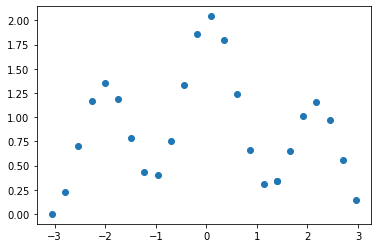

{1.3918606395721436: (0.33941579071779415, nan),
 1.6538606395721436: (0.6505525356205908, nan),
 1.9158606395721436: (1.0084825383141833, nan),
 2.1778606395721436: (1.1562039970272053, nan),
 2.4398606395721436: (0.9743952903804711, nan),
 2.7018606395721436: (0.5541312573091091, nan),
 2.9638606395721436: (0.14410761344424827, nan),
 -3.0573246676074426: (0.0, nan),
 -2.7953246676074426: (0.22581385161583967, nan),
 -2.5333246676074426: (0.7053124785188629, nan),
 -2.2713246676074426: (1.1688983885437665, nan),
 -2.0093246676074425: (1.3574766641118003, nan),
 -1.7473246676074425: (1.1821681499477563, nan),
 -1.4853246676074425: (0.7806648833616237, nan),
 -1.2233246676074425: (0.4346803972453017, nan),
 -0.9613246676074425: (0.3996506045473325, nan),
 -0.6993246676074425: (0.7503171194716742, nan),
 -0.4373246676074425: (1.333778539396917, nan),
 -0.17532466760744247: (1.8550420528144969, nan),
 0.08667533239255754: (2.0422924185909324, nan),
 0.34867533239255755: (1.79632838515544

In [8]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [669, 670, 673, 674],  [669, 670, 673, 674], [675] + list(range(678, 683))) # solvent


In [ ]:
# L37 (first-585), W38, D39, A40, L41 (last-668), G43 (first-683), W44, V45 (last-729), Y47(745-765), A77(1248-1257), E80(1290-1304), A82 (1312-1321)

In [ ]:
# Zero all nonbonded 1,4s -- barrier is now 250 kJ/mol
# Zero all nonbonded 1,4s and particle interactions -- barrier is now 2 kJ/mol
# Zero all nonbonded 1,4s and particle interactions if one of them involves REST region (mutated residue + 5 A radius) atom -- barrier is now 1750 kJ/mol
# Zero all nonbonded 1,4s and particle interactions if one of them involves REST region (mutated residue + 5 A radius) or solvent atom -- barrier is now 25 kJ/mol
# Zero all nonbonded 1,4s and particle interactions if one of them involves REST region (mutated residue + 5 A radius) or solvent atom near T42 -- barrier is now 2 kJ/mol

## Barnase:barstar complex T42A r-htf + REST2 (flattened torsions and exceptions) @ lambda = 0 -- play around with system 

In [5]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/0/"

with open(os.path.join(data_dir, f"0_complex_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

    
# with open(os.path.join(data_dir, f"0_apo_vacuum_0.pickle"), "rb") as f:
#     rhtf = pickle.load(f)
# # Remove barostat
# rhtf.hybrid_system.removeForce(0)

In [6]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
LYS1-N 6
LYS1-CA 7
LYS1-C 8
LYS1-O 9
LYS1-CB 10
LYS1-CG 11
LYS1-CD 12
LYS1-CE 13
LYS1-NZ 14
LYS1-H2 15
LYS1-HA 16
LYS1-HB3 17
LYS1-HB2 18
LYS1-HG2 19
LYS1-HG3 20
LYS1-HD2 21
LYS1-HD3 22
LYS1-HE3 23
LYS1-HE2 24
LYS1-HZ1 25
LYS1-HZ2 26
LYS1-HZ3 27
LYS2-N 28
LYS2-CA 29
LYS2-C 30
LYS2-O 31
LYS2-CB 32
LYS2-CG 33
LYS2-CD 34
LYS2-CE 35
LYS2-NZ 36
LYS2-H 37
LYS2-HA 38
LYS2-HB3 39
LYS2-HB2 40
LYS2-HG2 41
LYS2-HG3 42
LYS2-HD3 43
LYS2-HD2 44
LYS2-HE3 45
LYS2-HE2 46
LYS2-HZ1 47
LYS2-HZ2 48
LYS2-HZ3 49
ALA3-N 50
ALA3-CA 51
ALA3-C 52
ALA3-O 53
ALA3-CB 54
ALA3-H 55
ALA3-HA 56
ALA3-HB1 57
ALA3-HB2 58
ALA3-HB3 59
VAL4-N 60
VAL4-CA 61
VAL4-C 62
VAL4-O 63
VAL4-CB 64
VAL4-CG1 65
VAL4-CG2 66
VAL4-H 67
VAL4-HA 68
VAL4-HB 69
VAL4-HG11 70
VAL4-HG12 71
VAL4-HG13 72
VAL4-HG21 73
VAL4-HG22 74
VAL4-HG23 75
ILE5-N 76
ILE5-CA 77
ILE5-C 78
ILE5-O 79
ILE5-CB 80
ILE5-CG1 81
ILE5-CG2 82
ILE5-CD1 83
ILE5-H 84
ILE5-HA 85
ILE5-HB 86
ILE5-HG13 87
ILE5-HG12 88
ILE5-

ASP54-H 2211
ASP54-HA 2212
ASP54-HB2 2213
ASP54-HB3 2214
ILE55-N 2215
ILE55-CA 2216
ILE55-C 2217
ILE55-O 2218
ILE55-CB 2219
ILE55-CG1 2220
ILE55-CG2 2221
ILE55-CD1 2222
ILE55-H 2223
ILE55-HA 2224
ILE55-HB 2225
ILE55-HG13 2226
ILE55-HG12 2227
ILE55-HG21 2228
ILE55-HG22 2229
ILE55-HG23 2230
ILE55-HD11 2231
ILE55-HD12 2232
ILE55-HD13 2233
PHE56-N 2234
PHE56-CA 2235
PHE56-C 2236
PHE56-O 2237
PHE56-CB 2238
PHE56-CG 2239
PHE56-CD1 2240
PHE56-CD2 2241
PHE56-CE1 2242
PHE56-CE2 2243
PHE56-CZ 2244
PHE56-H 2245
PHE56-HA 2246
PHE56-HB3 2247
PHE56-HB2 2248
PHE56-HD1 2249
PHE56-HD2 2250
PHE56-HE1 2251
PHE56-HE2 2252
PHE56-HZ 2253
SER57-N 2254
SER57-CA 2255
SER57-C 2256
SER57-O 2257
SER57-CB 2258
SER57-OG 2259
SER57-H 2260
SER57-HA 2261
SER57-HB2 2262
SER57-HB3 2263
SER57-HG 2264
ASN58-N 2265
ASN58-CA 2266
ASN58-C 2267
ASN58-O 2268
ASN58-CB 2269
ASN58-CG 2270
ASN58-OD1 2271
ASN58-ND2 2272
ASN58-H 2273
ASN58-HA 2274
ASN58-HB3 2275
ASN58-HB2 2276
ASN58-HD21 2277
ASN58-HD22 2278
ARG59-N 2279
ARG59-CA 22

HOH639-O 4461
HOH639-H1 4462
HOH639-H2 4463
HOH640-O 4464
HOH640-H1 4465
HOH640-H2 4466
HOH641-O 4467
HOH641-H1 4468
HOH641-H2 4469
HOH642-O 4470
HOH642-H1 4471
HOH642-H2 4472
HOH643-O 4473
HOH643-H1 4474
HOH643-H2 4475
HOH644-O 4476
HOH644-H1 4477
HOH644-H2 4478
HOH645-O 4479
HOH645-H1 4480
HOH645-H2 4481
HOH646-O 4482
HOH646-H1 4483
HOH646-H2 4484
HOH647-O 4485
HOH647-H1 4486
HOH647-H2 4487
HOH648-O 4488
HOH648-H1 4489
HOH648-H2 4490
HOH649-O 4491
HOH649-H1 4492
HOH649-H2 4493
HOH650-O 4494
HOH650-H1 4495
HOH650-H2 4496
HOH651-O 4497
HOH651-H1 4498
HOH651-H2 4499
HOH652-O 4500
HOH652-H1 4501
HOH652-H2 4502
HOH653-O 4503
HOH653-H1 4504
HOH653-H2 4505
HOH654-O 4506
HOH654-H1 4507
HOH654-H2 4508
HOH655-O 4509
HOH655-H1 4510
HOH655-H2 4511
HOH656-O 4512
HOH656-H1 4513
HOH656-H2 4514
HOH657-O 4515
HOH657-H1 4516
HOH657-H2 4517
HOH658-O 4518
HOH658-H1 4519
HOH658-H2 4520
HOH659-O 4521
HOH659-H1 4522
HOH659-H2 4523
HOH660-O 4524
HOH660-H1 4525
HOH660-H2 4526
HOH661-O 4527
HOH661-H1 4528
HOH

HOH1474-O 6960
HOH1474-H1 6961
HOH1474-H2 6962
HOH1475-O 6963
HOH1475-H1 6964
HOH1475-H2 6965
HOH1476-O 6966
HOH1476-H1 6967
HOH1476-H2 6968
HOH1477-O 6969
HOH1477-H1 6970
HOH1477-H2 6971
HOH1478-O 6972
HOH1478-H1 6973
HOH1478-H2 6974
HOH1479-O 6975
HOH1479-H1 6976
HOH1479-H2 6977
HOH1480-O 6978
HOH1480-H1 6979
HOH1480-H2 6980
HOH1481-O 6981
HOH1481-H1 6982
HOH1481-H2 6983
HOH1482-O 6984
HOH1482-H1 6985
HOH1482-H2 6986
HOH1483-O 6987
HOH1483-H1 6988
HOH1483-H2 6989
HOH1484-O 6990
HOH1484-H1 6991
HOH1484-H2 6992
HOH1485-O 6993
HOH1485-H1 6994
HOH1485-H2 6995
HOH1486-O 6996
HOH1486-H1 6997
HOH1486-H2 6998
HOH1487-O 6999
HOH1487-H1 7000
HOH1487-H2 7001
HOH1488-O 7002
HOH1488-H1 7003
HOH1488-H2 7004
HOH1489-O 7005
HOH1489-H1 7006
HOH1489-H2 7007
HOH1490-O 7008
HOH1490-H1 7009
HOH1490-H2 7010
HOH1491-O 7011
HOH1491-H1 7012
HOH1491-H2 7013
HOH1492-O 7014
HOH1492-H1 7015
HOH1492-H2 7016
HOH1493-O 7017
HOH1493-H1 7018
HOH1493-H2 7019
HOH1495-O 7020
HOH1495-H1 7021
HOH1495-H2 7022
HOH1496-O 702

HOH2311-H1 9460
HOH2311-H2 9461
HOH2312-O 9462
HOH2312-H1 9463
HOH2312-H2 9464
HOH2313-O 9465
HOH2313-H1 9466
HOH2313-H2 9467
HOH2314-O 9468
HOH2314-H1 9469
HOH2314-H2 9470
HOH2315-O 9471
HOH2315-H1 9472
HOH2315-H2 9473
HOH2316-O 9474
HOH2316-H1 9475
HOH2316-H2 9476
HOH2317-O 9477
HOH2317-H1 9478
HOH2317-H2 9479
HOH2318-O 9480
HOH2318-H1 9481
HOH2318-H2 9482
HOH2319-O 9483
HOH2319-H1 9484
HOH2319-H2 9485
HOH2320-O 9486
HOH2320-H1 9487
HOH2320-H2 9488
HOH2321-O 9489
HOH2321-H1 9490
HOH2321-H2 9491
HOH2322-O 9492
HOH2322-H1 9493
HOH2322-H2 9494
HOH2323-O 9495
HOH2323-H1 9496
HOH2323-H2 9497
HOH2324-O 9498
HOH2324-H1 9499
HOH2324-H2 9500
HOH2325-O 9501
HOH2325-H1 9502
HOH2325-H2 9503
HOH2326-O 9504
HOH2326-H1 9505
HOH2326-H2 9506
HOH2327-O 9507
HOH2327-H1 9508
HOH2327-H2 9509
HOH2328-O 9510
HOH2328-H1 9511
HOH2328-H2 9512
HOH2329-O 9513
HOH2329-H1 9514
HOH2329-H2 9515
HOH2330-O 9516
HOH2330-H1 9517
HOH2330-H2 9518
HOH2331-O 9519
HOH2331-H1 9520
HOH2331-H2 9521
HOH2332-O 9522
HOH2332-H1 95

HOH3082-H2 11768
HOH3083-O 11769
HOH3083-H1 11770
HOH3083-H2 11771
HOH3084-O 11772
HOH3084-H1 11773
HOH3084-H2 11774
HOH3085-O 11775
HOH3085-H1 11776
HOH3085-H2 11777
HOH3086-O 11778
HOH3086-H1 11779
HOH3086-H2 11780
HOH3087-O 11781
HOH3087-H1 11782
HOH3087-H2 11783
HOH3088-O 11784
HOH3088-H1 11785
HOH3088-H2 11786
HOH3089-O 11787
HOH3089-H1 11788
HOH3089-H2 11789
HOH3090-O 11790
HOH3090-H1 11791
HOH3090-H2 11792
HOH3091-O 11793
HOH3091-H1 11794
HOH3091-H2 11795
HOH3092-O 11796
HOH3092-H1 11797
HOH3092-H2 11798
HOH3093-O 11799
HOH3093-H1 11800
HOH3093-H2 11801
HOH3094-O 11802
HOH3094-H1 11803
HOH3094-H2 11804
HOH3095-O 11805
HOH3095-H1 11806
HOH3095-H2 11807
HOH3096-O 11808
HOH3096-H1 11809
HOH3096-H2 11810
HOH3097-O 11811
HOH3097-H1 11812
HOH3097-H2 11813
HOH3098-O 11814
HOH3098-H1 11815
HOH3098-H2 11816
HOH3099-O 11817
HOH3099-H1 11818
HOH3099-H2 11819
HOH3100-O 11820
HOH3100-H1 11821
HOH3100-H2 11822
HOH3101-O 11823
HOH3101-H1 11824
HOH3101-H2 11825
HOH3102-O 11826
HOH3102-H1 11827


HOH4063-H1 14710
HOH4063-H2 14711
HOH4064-O 14712
HOH4064-H1 14713
HOH4064-H2 14714
HOH4065-O 14715
HOH4065-H1 14716
HOH4065-H2 14717
HOH4066-O 14718
HOH4066-H1 14719
HOH4066-H2 14720
HOH4067-O 14721
HOH4067-H1 14722
HOH4067-H2 14723
HOH4068-O 14724
HOH4068-H1 14725
HOH4068-H2 14726
HOH4069-O 14727
HOH4069-H1 14728
HOH4069-H2 14729
HOH4070-O 14730
HOH4070-H1 14731
HOH4070-H2 14732
HOH4071-O 14733
HOH4071-H1 14734
HOH4071-H2 14735
HOH4072-O 14736
HOH4072-H1 14737
HOH4072-H2 14738
HOH4073-O 14739
HOH4073-H1 14740
HOH4073-H2 14741
HOH4074-O 14742
HOH4074-H1 14743
HOH4074-H2 14744
HOH4075-O 14745
HOH4075-H1 14746
HOH4075-H2 14747
HOH4076-O 14748
HOH4076-H1 14749
HOH4076-H2 14750
HOH4077-O 14751
HOH4077-H1 14752
HOH4077-H2 14753
HOH4078-O 14754
HOH4078-H1 14755
HOH4078-H2 14756
HOH4079-O 14757
HOH4079-H1 14758
HOH4079-H2 14759
HOH4080-O 14760
HOH4080-H1 14761
HOH4080-H2 14762
HOH4081-O 14763
HOH4081-H1 14764
HOH4081-H2 14765
HOH4082-O 14766
HOH4082-H1 14767
HOH4082-H2 14768
HOH4083-O 14769


HOH4981-H2 17459
HOH4982-O 17460
HOH4982-H1 17461
HOH4982-H2 17462
HOH4983-O 17463
HOH4983-H1 17464
HOH4983-H2 17465
HOH4984-O 17466
HOH4984-H1 17467
HOH4984-H2 17468
HOH4985-O 17469
HOH4985-H1 17470
HOH4985-H2 17471
HOH4986-O 17472
HOH4986-H1 17473
HOH4986-H2 17474
HOH4987-O 17475
HOH4987-H1 17476
HOH4987-H2 17477
HOH4988-O 17478
HOH4988-H1 17479
HOH4988-H2 17480
HOH4989-O 17481
HOH4989-H1 17482
HOH4989-H2 17483
HOH4990-O 17484
HOH4990-H1 17485
HOH4990-H2 17486
HOH4991-O 17487
HOH4991-H1 17488
HOH4991-H2 17489
HOH4992-O 17490
HOH4992-H1 17491
HOH4992-H2 17492
HOH4993-O 17493
HOH4993-H1 17494
HOH4993-H2 17495
HOH4994-O 17496
HOH4994-H1 17497
HOH4994-H2 17498
HOH4995-O 17499
HOH4995-H1 17500
HOH4995-H2 17501
HOH4996-O 17502
HOH4996-H1 17503
HOH4996-H2 17504
HOH4997-O 17505
HOH4997-H1 17506
HOH4997-H2 17507
HOH4998-O 17508
HOH4998-H1 17509
HOH4998-H2 17510
HOH4999-O 17511
HOH4999-H1 17512
HOH4999-H2 17513
HOH5000-O 17514
HOH5000-H1 17515
HOH5000-H2 17516
HOH5001-O 17517
HOH5001-H1 17518


HOH5899-H1 20209
HOH5899-H2 20210
HOH5900-O 20211
HOH5900-H1 20212
HOH5900-H2 20213
HOH5901-O 20214
HOH5901-H1 20215
HOH5901-H2 20216
HOH5902-O 20217
HOH5902-H1 20218
HOH5902-H2 20219
HOH5904-O 20220
HOH5904-H1 20221
HOH5904-H2 20222
HOH5905-O 20223
HOH5905-H1 20224
HOH5905-H2 20225
HOH5906-O 20226
HOH5906-H1 20227
HOH5906-H2 20228
HOH5907-O 20229
HOH5907-H1 20230
HOH5907-H2 20231
HOH5908-O 20232
HOH5908-H1 20233
HOH5908-H2 20234
HOH5909-O 20235
HOH5909-H1 20236
HOH5909-H2 20237
HOH5910-O 20238
HOH5910-H1 20239
HOH5910-H2 20240
HOH5911-O 20241
HOH5911-H1 20242
HOH5911-H2 20243
HOH5912-O 20244
HOH5912-H1 20245
HOH5912-H2 20246
HOH5913-O 20247
HOH5913-H1 20248
HOH5913-H2 20249
HOH5914-O 20250
HOH5914-H1 20251
HOH5914-H2 20252
HOH5915-O 20253
HOH5915-H1 20254
HOH5915-H2 20255
HOH5916-O 20256
HOH5916-H1 20257
HOH5916-H2 20258
HOH5917-O 20259
HOH5917-H1 20260
HOH5917-H2 20261
HOH5918-O 20262
HOH5918-H1 20263
HOH5918-H2 20264
HOH5919-O 20265
HOH5919-H1 20266
HOH5919-H2 20267
HOH5920-O 20268


HOH6819-O 22959
HOH6819-H1 22960
HOH6819-H2 22961
HOH6820-O 22962
HOH6820-H1 22963
HOH6820-H2 22964
HOH6821-O 22965
HOH6821-H1 22966
HOH6821-H2 22967
HOH6822-O 22968
HOH6822-H1 22969
HOH6822-H2 22970
HOH6823-O 22971
HOH6823-H1 22972
HOH6823-H2 22973
HOH6824-O 22974
HOH6824-H1 22975
HOH6824-H2 22976
HOH6825-O 22977
HOH6825-H1 22978
HOH6825-H2 22979
HOH6826-O 22980
HOH6826-H1 22981
HOH6826-H2 22982
HOH6827-O 22983
HOH6827-H1 22984
HOH6827-H2 22985
HOH6828-O 22986
HOH6828-H1 22987
HOH6828-H2 22988
HOH6829-O 22989
HOH6829-H1 22990
HOH6829-H2 22991
HOH6830-O 22992
HOH6830-H1 22993
HOH6830-H2 22994
HOH6831-O 22995
HOH6831-H1 22996
HOH6831-H2 22997
HOH6832-O 22998
HOH6832-H1 22999
HOH6832-H2 23000
HOH6833-O 23001
HOH6833-H1 23002
HOH6833-H2 23003
HOH6834-O 23004
HOH6834-H1 23005
HOH6834-H2 23006
HOH6835-O 23007
HOH6835-H1 23008
HOH6835-H2 23009
HOH6836-O 23010
HOH6836-H1 23011
HOH6836-H2 23012
HOH6837-O 23013
HOH6837-H1 23014
HOH6837-H2 23015
HOH6838-O 23016
HOH6838-H1 23017
HOH6838-H2 23018


HOH7653-H1 25459
HOH7653-H2 25460
HOH7654-O 25461
HOH7654-H1 25462
HOH7654-H2 25463
HOH7655-O 25464
HOH7655-H1 25465
HOH7655-H2 25466
HOH7656-O 25467
HOH7656-H1 25468
HOH7656-H2 25469
HOH7657-O 25470
HOH7657-H1 25471
HOH7657-H2 25472
HOH7658-O 25473
HOH7658-H1 25474
HOH7658-H2 25475
HOH7659-O 25476
HOH7659-H1 25477
HOH7659-H2 25478
HOH7660-O 25479
HOH7660-H1 25480
HOH7660-H2 25481
HOH7661-O 25482
HOH7661-H1 25483
HOH7661-H2 25484
HOH7662-O 25485
HOH7662-H1 25486
HOH7662-H2 25487
HOH7663-O 25488
HOH7663-H1 25489
HOH7663-H2 25490
HOH7664-O 25491
HOH7664-H1 25492
HOH7664-H2 25493
HOH7665-O 25494
HOH7665-H1 25495
HOH7665-H2 25496
HOH7666-O 25497
HOH7666-H1 25498
HOH7666-H2 25499
HOH7667-O 25500
HOH7667-H1 25501
HOH7667-H2 25502
HOH7668-O 25503
HOH7668-H1 25504
HOH7668-H2 25505
HOH7669-O 25506
HOH7669-H1 25507
HOH7669-H2 25508
HOH7670-O 25509
HOH7670-H1 25510
HOH7670-H2 25511
HOH7671-O 25512
HOH7671-H1 25513
HOH7671-H2 25514
HOH7672-O 25515
HOH7672-H1 25516
HOH7672-H2 25517
HOH7673-O 25518


HOH8573-H2 28208
HOH8574-O 28209
HOH8574-H1 28210
HOH8574-H2 28211
HOH8575-O 28212
HOH8575-H1 28213
HOH8575-H2 28214
HOH8576-O 28215
HOH8576-H1 28216
HOH8576-H2 28217
HOH8577-O 28218
HOH8577-H1 28219
HOH8577-H2 28220
HOH8578-O 28221
HOH8578-H1 28222
HOH8578-H2 28223
HOH8579-O 28224
HOH8579-H1 28225
HOH8579-H2 28226
HOH8580-O 28227
HOH8580-H1 28228
HOH8580-H2 28229
HOH8581-O 28230
HOH8581-H1 28231
HOH8581-H2 28232
HOH8582-O 28233
HOH8582-H1 28234
HOH8582-H2 28235
HOH8583-O 28236
HOH8583-H1 28237
HOH8583-H2 28238
HOH8584-O 28239
HOH8584-H1 28240
HOH8584-H2 28241
HOH8585-O 28242
HOH8585-H1 28243
HOH8585-H2 28244
HOH8586-O 28245
HOH8586-H1 28246
HOH8586-H2 28247
HOH8587-O 28248
HOH8587-H1 28249
HOH8587-H2 28250
HOH8588-O 28251
HOH8588-H1 28252
HOH8588-H2 28253
HOH8589-O 28254
HOH8589-H1 28255
HOH8589-H2 28256
HOH8590-O 28257
HOH8590-H1 28258
HOH8590-H2 28259
HOH8591-O 28260
HOH8591-H1 28261
HOH8591-H2 28262
HOH8592-O 28263
HOH8592-H1 28264
HOH8592-H2 28265
HOH8593-O 28266
HOH8593-H1 28267


In [7]:
rhtf.hybrid_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b0157f9e7e0> >,
 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b0157f9e720> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b0157f9e1b0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b01c21d51b0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b01c21d5210> >]

In [7]:
# rest_atoms = list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322))
# rest_atoms = list(range(585,669)) + list(range(683, 730)) + list(range(745, 766)) + list(range(1248, 1258)) + list(range(1290, 1305)) + list(range(1312, 1322)) + list(range(1441, 14877)) # include solvent atoms
traj = md.Trajectory(np.array(rhtf.hybrid_positions), rhtf.hybrid_topology)
# rest_atoms = list(md.compute_neighbors(traj, 0.5, list(range(669, 683)))[0])
rest_atoms = list(range(604, 628))

# Turn off all nonbonded 1,4s
for exception in range(rhtf.hybrid_system.getForce(4).getNumExceptions()):
    p1, p2, q, sigma, epsilon = rhtf.hybrid_system.getForce(4).getExceptionParameters(exception)
    if p1 in rest_atoms or p2 in rest_atoms:
        rhtf.hybrid_system.getForce(4).setExceptionParameters(exception, p1, p2, q*0, sigma, epsilon*0)

# Turn off all nonbonded interactions
for particle in range(rhtf.hybrid_system.getForce(4).getNumParticles()):
    q, sigma, epsilon = rhtf.hybrid_system.getForce(4).getParticleParameters(particle)
    if particle in rest_atoms:
        rhtf.hybrid_system.getForce(4).setParticleParameters(particle, q*0, sigma, epsilon*0)



INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.7997, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.7997, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.7997), unit=nanometer)]
INFO:REST:No unknown forces.


-20906.796778012733
1.1298606
-185701.3957314523


INFO:root:Rotating by 0.2159297047460207 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by -6.021185307179585 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.262 radians
INFO:roo

-185699.95459856512
-185693.49565980647
-185683.6335699733
-185667.09177712235
-185636.6391226812
-185623.27921638614
-185655.9099097622
-185676.53993369028
-185670.4394498849
-185648.6684073452
-185529.85763146414
-184290.3308587797
-184942.28598316753
-185407.72410271867
-185242.55884998202
-185329.8418040002
-185661.19970613255
-185691.68986794914
-185693.08691476073
-185693.34603764943


INFO:root:Rotating by 0.26200000000000095 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000018 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


-185694.366876688
-185696.49993155003
-185699.3368527425
-185701.3238869567
raw d: {1.3918606395721436: (-185699.95459856512, nan), 1.6538606395721436: (-185693.49565980647, nan), 1.9158606395721436: (-185683.6335699733, nan), 2.1778606395721436: (-185667.09177712235, nan), 2.4398606395721436: (-185636.6391226812, nan), 2.7018606395721436: (-185623.27921638614, nan), 2.9638606395721436: (-185655.9099097622, nan), -3.0573246676074426: (-185676.53993369028, nan), -2.7953246676074426: (-185670.4394498849, nan), -2.5333246676074426: (-185648.6684073452, nan), -2.2713246676074426: (-185529.85763146414, nan), -2.0093246676074425: (-184290.3308587797, nan), -1.7473246676074425: (-184942.28598316753, nan), -1.4853246676074425: (-185407.72410271867, nan), -1.2233246676074425: (-185242.55884998202, nan), -0.9613246676074425: (-185329.8418040002, nan), -0.6993246676074425: (-185661.19970613255, nan), -0.4373246676074425: (-185691.68986794914, nan), -0.17532466760744247: (-185693.08691476073, nan)

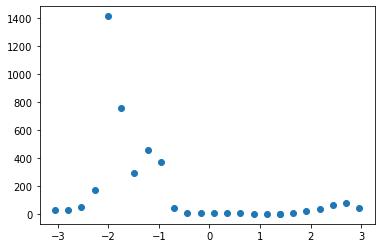

{1.3918606395721436: (1.3692883915791754, nan),
 1.6538606395721436: (7.828227150224848, nan),
 1.9158606395721436: (17.69031698341132, nan),
 2.1778606395721436: (34.23210983435274, nan),
 2.4398606395721436: (64.68476427550195, nan),
 2.7018606395721436: (78.04467057055444, nan),
 2.9638606395721436: (45.413977194490144, nan),
 -3.0573246676074426: (24.78395326642203, nan),
 -2.7953246676074426: (30.884437071799766, nan),
 -2.5333246676074426: (52.65547961150878, nan),
 -2.2713246676074426: (171.46625549255987, nan),
 -2.0093246676074425: (1410.9930281770066, nan),
 -1.7473246676074425: (759.0379037891689, nan),
 -1.4853246676074425: (293.59978423803113, nan),
 -1.2233246676074425: (458.76503697468434, nan),
 -0.9613246676074425: (371.48208295649965, nan),
 -0.6993246676074425: (40.124180824146606, nan),
 -0.4373246676074425: (9.634019007557072, nan),
 -0.17532466760744247: (8.236972195969429, nan),
 0.08667533239255754: (7.977849307266297, nan),
 0.34867533239255755: (6.957010268699

In [8]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [669, 670, 673, 674],  [669, 670, 673, 674], [675] + list(range(678, 683))) # solvent


In [ ]:
# L37 (first-585), W38, D39, A40, L41 (last-668), G43 (first-683), W44, V45 (last-729), Y47(745-765), A77(1248-1257), E80(1290-1304), A82 (1312-1321)

In [ ]:
# Zero all nonbonded 1,4s and particle interactions if one of them involves REST region (mutated residue + 5 A radius) or solvent atom near T42 -- barrier is now 2 kJ/mol

## Pull water atoms near a residue

In [8]:
import mdtraj as md

In [17]:
traj = md.Trajectory(np.array(rhtf.hybrid_positions), rhtf.hybrid_topology)

In [17]:
md.compute_neighbors(traj, 0.8, list(range(669, 683)) + list(range(14877, 14881)), haystack_indices=list(range(1441, rhtf.hybrid_topology.n_atoms)))[0]

array([ 1441,  1442,  1443,  5514,  5707,  5708,  5709,  5954,  6042,
        6109,  6110,  6111,  6190,  6191,  6932,  6933,  7259,  7423,
        7424,  7425,  7429,  7430,  7431,  7435,  7436,  7437,  7447,
        7448,  7449,  7472,  7476,  7564,  7565,  7566,  7587,  7603,
        7604,  7605,  7641,  7654,  7655,  7656,  7717,  7718,  7719,
        7735,  7736,  7737,  7764,  7918,  7919,  7920,  7924,  7925,
        7926,  8053,  8054,  8055,  8059,  8065,  8066,  8067,  8086,
        8087,  8088,  8104,  8105,  8106,  8185,  8186,  8187,  8189,
        8191,  8192,  8193,  8194,  8195,  8203,  8204,  8205,  8210,
        8211,  8251,  8252,  8253,  8287,  8288,  8289,  8326,  8327,
        8328,  8349,  8350,  8351,  8352,  8353,  8354,  8355,  8380,
        8381,  8382,  8387,  8388,  8395,  8396,  8397,  8452,  8453,
        8454,  8581,  8582,  8583,  8629,  8630,  8631, 14877, 14878,
       14879, 14880])